In [1]:
import gymnasium as gym
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure

from evaluation.evalcallback_feedback import CurriculumEvalCallback


2024-04-11 12:52:41.127589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 12:52:48.619481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_training_log(logger_path):
    training_log = np.load(logger_path + "/evaluations.npz", allow_pickle=True)

    reward_dict = training_log["results_dict"]
    success = training_log["successes"]

    averaged_dicts = []

    for row in reward_dict:
        sum_dict = {}
        for col in row:
            for key in col:
                sum_dict[key] = sum_dict.get(key, 0) + col[key]

        avg_dict = {key: value/len(row) for key, value in sum_dict.items()}
        averaged_dicts.append(avg_dict)

    reward_df = pd.DataFrame(averaged_dicts)

    return reward_df, success

In [21]:
reward_main = []
reward_task = []
success_list = []
task_length = []

In [22]:
task_list = ["[Approach Block]", "[Align Velocities]", "[Push to Goal]"]
best_sample_idx = [2,0,1]

logger_path = "./logs/Fetch/Push_6/"

In [23]:
for idx, task in enumerate(task_list):
    path = logger_path + task + f"/sample_{best_sample_idx[idx]}"
    
    reward_df, success = load_training_log(path)

    for key in reward_df.keys():
        print(key)

    reward_main.append(reward_df["main"])
    reward_task.append(reward_df["task"])
    success_list.append(success)
    task_length.append(len(reward_df["main"]))

distance_to_block
main
task
distance_to_block
velocity_alignment_reward
main
task
distance_to_block
velocity_alignment_reward
distance_to_goal
main
task


In [24]:
reward_main = np.concatenate(reward_main, axis=0)
reward_task = np.concatenate(reward_task, axis=0)
success = np.concatenate(success_list, axis=0).mean(axis=1)

In [25]:
# Load reward addition
path = logger_path + "reward_addition"
reward_df_addition, success_addition = load_training_log(path)

reward_main_addition = reward_df_addition["main"]
reward_task_addition = reward_df_addition["task"]
success_addition = success_addition.mean(axis=1)

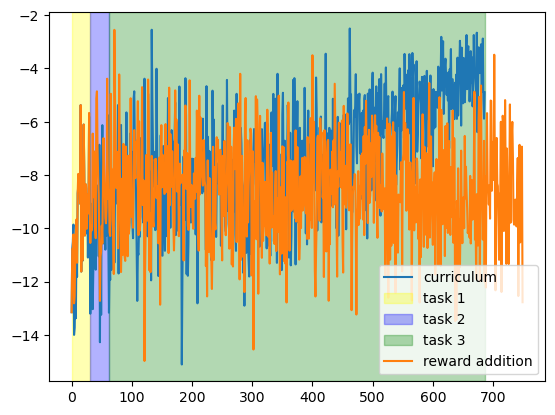

In [26]:
plt.plot(reward_main, label='curriculum')
plt.axvspan(0, task_length[0], color='yellow', alpha=0.3, label='task 1')
plt.axvspan(task_length[0], task_length[0]+task_length[1], color='blue', alpha=0.3, label='task 2')
plt.axvspan(task_length[0]+task_length[1], task_length[0]+task_length[1]+task_length[2], color='green', alpha=0.3, label='task 3')
# plt.axvspan(task_length[0]+task_length[1]+task_length[2], task_length[0]+task_length[1]+task_length[2]+task_length[3], color='orange', alpha=0.3, label='task 4')
plt.plot(reward_main_addition, label='reward addition')
plt.legend()
plt.savefig(logger_path+"reward_main.png")

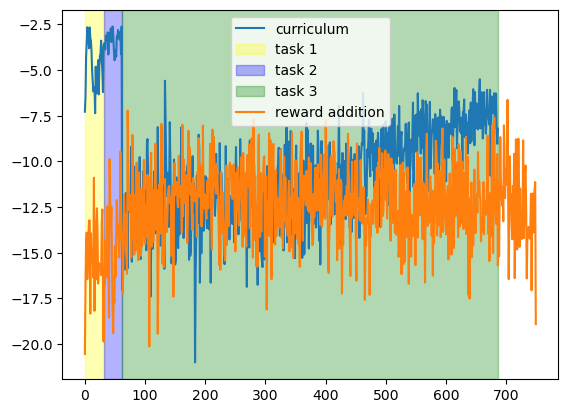

In [27]:
plt.plot(reward_task, label='curriculum')
plt.axvspan(0, task_length[0], color='yellow', alpha=0.3, label='task 1')
plt.axvspan(task_length[0], task_length[0]+task_length[1], color='blue', alpha=0.3, label='task 2')
plt.axvspan(task_length[0]+task_length[1], task_length[0]+task_length[1]+task_length[2], color='green', alpha=0.3, label='task 3')
# plt.axvspan(task_length[0]+task_length[1]+task_length[2], task_length[0]+task_length[1]+task_length[2]+task_length[3], color='orange', alpha=0.3, label='task 4')
plt.plot(reward_task_addition, label='reward addition')
# plt.plot([reward_task_addition[4*i] for i in range(150)], label='reward addition')
plt.legend()
plt.savefig(logger_path+"reward_task.png")

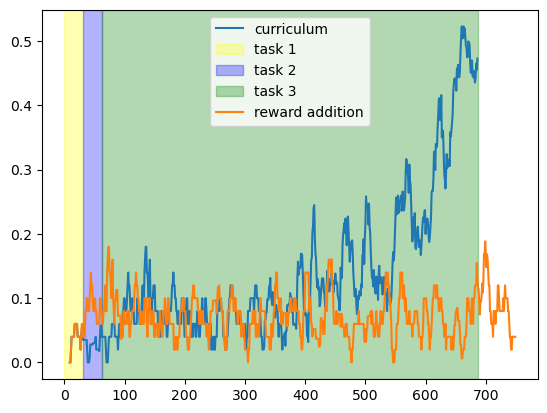

In [28]:
success_moving_avg = pd.Series(success).rolling(10).mean()
plt.plot(success_moving_avg, label='curriculum')
# plt.plot(success)
plt.axvspan(0, task_length[0], color='yellow', alpha=0.3, label='task 1')
plt.axvspan(task_length[0], task_length[0]+task_length[1], color='blue', alpha=0.3, label='task 2')
plt.axvspan(task_length[0]+task_length[1], task_length[0]+task_length[1]+task_length[2], color='green', alpha=0.3, label='task 3')
# plt.axvspan(task_length[0]+task_length[1]+task_length[2], task_length[0]+task_length[1]+task_length[2]+task_length[3], color='orange', alpha=0.3, label='task 4')
success_addition_avg = pd.Series(success_addition).rolling(10).mean()
plt.plot(success_addition_avg, label='reward addition')
# plt.plot(success_addition, label='reward addition')
# plt.plot([success_addition[4*i] for i in range(150)], label='reward addition')
plt.legend()
plt.savefig(logger_path+"success.png")

# Env Test

In [15]:
import Curriculum

# env = make_vec_env("Curriculum/Fetch_Push-v0")
env = gym.make("Curriculum/Fetch_Push-v0")

In [19]:
obs = env.reset()
print(obs)

# model = SAC.load("./logs/AntMaze_UMaze_SAC/goal_orientation/sample_0/final_model.zip")

for i in range(100):
#     action, _states = model.predict(obs, deterministic=True)
    obs, rewards, _, _, info = env.step(env.action_space.sample())
    print(info["reward_dict"])
    print(rewards)

({'observation': array([ 1.34815922e+00,  7.48950902e-01,  4.13618685e-01,  1.46577059e+00,
        8.88054578e-01,  4.24702091e-01,  1.17611362e-01,  1.39103675e-01,
        1.10834063e-02, -1.50944836e-06,  1.25159772e-03, -8.82449685e-08,
        1.35761490e-07,  4.67863609e-15,  9.30919601e-04, -4.11979931e-05,
        3.89350461e-05,  5.03907166e-08, -7.75241793e-08,  2.87432303e-20,
       -9.30921536e-04,  4.11967353e-05,  7.89271962e-06,  3.79757618e-07,
        4.39314913e-05]), 'achieved_goal': array([1.46577059, 0.88805458, 0.42470209]), 'desired_goal': array([1.35527149, 0.62690261, 0.42469975])}, {})
{'distance_to_block': 0.18432214182343687, 'z_adjustment_reward': -0.02367003356813513, 'velocity_control_reward': -0.04008245665393485, 'distance_to_goal': 0.2835672761000625, 'distance_reward': -0.2835672761000625, 'main': -1.0, 'task': -0.5316419081455693}
-0.5316419081455693
{'distance_to_block': 0.18716771841795965, 'z_adjustment_reward': -0.05186386226702211, 'velocity_c

{'distance_to_block': 0.45025143419959884, 'z_adjustment_reward': -0.15695975300237047, 'velocity_control_reward': -0.02727237947013507, 'distance_to_goal': 0.2835672843497017, 'distance_reward': -0.2835672843497017, 'main': -1.0, 'task': -0.9180508510218061}
-0.9180508510218061
{'distance_to_block': 0.43144933610758013, 'z_adjustment_reward': -0.1692246525137428, 'velocity_control_reward': -0.02683431431919325, 'distance_to_goal': 0.28356728434970274, 'distance_reward': -0.28356728434970274, 'main': -1.0, 'task': -0.911075587290219}
-0.911075587290219
{'distance_to_block': 0.4163858781107785, 'z_adjustment_reward': -0.18977314528017203, 'velocity_control_reward': -0.024741767001926103, 'distance_to_goal': 0.2835672843497033, 'distance_reward': -0.2835672843497033, 'main': -1.0, 'task': -0.91446807474258}
-0.91446807474258
{'distance_to_block': 0.42327045807745944, 'z_adjustment_reward': -0.1704919253474652, 'velocity_control_reward': -0.027767180084859143, 'distance_to_goal': 0.283567

{'distance_to_block': 0.4912727779975408, 'z_adjustment_reward': -0.14275696471176552, 'velocity_control_reward': -0.03469890057005415, 'distance_to_goal': 0.28356727882624794, 'distance_reward': -0.28356727882624794, 'main': -1.0, 'task': -0.9522959221056084}
-0.9522959221056084
{'distance_to_block': 0.4843643877569848, 'z_adjustment_reward': -0.14562950400589475, 'velocity_control_reward': -0.014455675026028946, 'distance_to_goal': 0.2835672788298057, 'distance_reward': -0.2835672788298057, 'main': -1.0, 'task': -0.9280168456187142}
-0.9280168456187142
{'distance_to_block': 0.45115298532311243, 'z_adjustment_reward': -0.13557672116555614, 'velocity_control_reward': -0.030991321299029394, 'distance_to_goal': 0.28356727883185295, 'distance_reward': -0.28356727883185295, 'main': -1.0, 'task': -0.9012883066195508}
-0.9012883066195508
{'distance_to_block': 0.41296355164075915, 'z_adjustment_reward': -0.12256263956413321, 'velocity_control_reward': -0.027275321128609198, 'distance_to_goal'

{'distance_to_block': 0.2536913425086961, 'z_adjustment_reward': -0.03931791837867593, 'velocity_control_reward': -0.02477505862479036, 'distance_to_goal': 0.28356727883462657, 'distance_reward': -0.28356727883462657, 'main': -1.0, 'task': -0.601351598346789}
-0.601351598346789
{'distance_to_block': 0.23807076527061588, 'z_adjustment_reward': -0.054333667612663894, 'velocity_control_reward': -0.027676703991785186, 'distance_to_goal': 0.28356727883462657, 'distance_reward': -0.28356727883462657, 'main': -1.0, 'task': -0.6036484157096915}
-0.6036484157096915
{'distance_to_block': 0.26288841960422427, 'z_adjustment_reward': -0.0547301942583851, 'velocity_control_reward': -0.025908940036554095, 'distance_to_goal': 0.28356727883462657, 'distance_reward': -0.28356727883462657, 'main': -1.0, 'task': -0.62709483273379}
-0.62709483273379
{'distance_to_block': 0.252804386087157, 'z_adjustment_reward': -0.032431098216503695, 'velocity_control_reward': -0.028752505687909262, 'distance_to_goal': 0.

In [17]:
goal_pos = obs['desired_goal']
xyz_coord = obs['observation'][0][:3]
print(xyz_coord)
distance= np.linalg.norm(goal_pos - xyz_coord[:2])

distance

[-3.73005146 -4.08769301  0.75      ]


8.57690137909474

In [ ]:
-np.linalg.norm([1.3408, 0.75647, 0.41671] - [0.144742, 0.8211249, 0.42469975]) + 

In [18]:
rewards

NameError: name 'rewards' is not defined

In [ ]:
model.policy